In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *
from scipy.signal import medfilt
from scipy.stats import sem, ranksums
%matplotlib inline
%load_ext autoreload
%autoreload 2
sns.set(font_scale=2, style='ticks')

In [2]:
vol_file = '../Analysis/depreciated/analysis_sections_ablation.csv'
dat_xls_file = pd.read_csv(vol_file)
dat_xls_file['folder'] = dat_xls_file['folder'].apply(lambda x: f'{x:0>8}')
t_pre = 100 # time window pre-swim
t_post = 350 # time window post-swim
t_len = t_pre+t_post
t_sig = 300 # time used for significance test after swim
non_spike_thres = 100
k_spk = boxcarKernel(sigma=61)
k_sub = 10

In [3]:
def search_paired_data(row, flist):
    if 'before' not in row['fish']:
        return False
    fish = row['fish'][:-6]
    for _, row_ in flist.iterrows():
        if row_['folder'] != row['folder']:
            continue
        if row_['fish'] == fish+'after':
            return True
    return False

## Check spike shape

In [4]:
def spk_shape(spk_list, dff):
    spk_ = []
    for t_ in spk_list:
        if t_+30<len(dff):
            spk_.append(dff[t_-30:t_+30])
    spk_ = np.array(spk_)
    return spk_.mean(axis=0)

In [5]:
cell_shape = []
plot_ = False

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    dir_folder = '/nrs/ahrens/Ziqiang/Takashi_DRN_project/ProcessedData/'
    dat_dir = dir_folder+f'{folder}/{fish}before/Data/'
    dff = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff = dff - np.nanmedian(dff, axis=1, keepdims=True)
    num_cell = spk.shape[0]
    spk = np.r_['-1', np.zeros((num_cell, 600)), spk]
    
    dat_dir = dir_folder+f'{folder}/{fish}after/Data/'
    dff_ = np.load(dat_dir+'Voltr_spikes.npz')['voltrs']
    spk_ = np.load(dat_dir+'Voltr_spikes.npz')['spk']
    dff_ = dff_ - np.nanmedian(dff_, axis=1, keepdims=True)
    num_cell = spk_.shape[0]
    spk_ = np.r_['-1', np.zeros((num_cell, 600)), spk_]
    
    for n_cell in range(num_cell):
        if (spk[n_cell].sum()<100) or (spk_[n_cell].sum()<100):
            continue
        spk_shape_b = spk_shape(np.where(spk[n_cell])[0], dff[n_cell])
        spk_shape_a = spk_shape(np.where(spk_[n_cell])[0], dff_[n_cell])        
        var_ = min(spk_shape_b.std(), spk_shape_a.std())
        err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
        if not np.isnan(err_/var_):
            cell_shape.append(err_/var_)
        if plot_:
            plt.plot(spk_shape_b)
            plt.plot(spk_shape_a)
            var_ = min(spk_shape_b.std(), spk_shape_a.std())
            err_ = np.sqrt(((spk_shape_a-spk_shape_b)**2).mean())
            plt.title(err_/var_)
            plt.show()

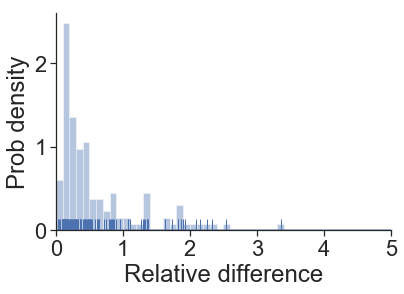

In [6]:
sns.distplot(np.array(cell_shape)**2, hist=True, rug=True, bins=np.arange(0, 10, 0.1))
plt.ylabel('Prob density')
plt.xlabel('Relative difference')
plt.xlim([0, 5])
sns.despine()
plt.show()

## Check spike rates

This analysis is limited to the cell with invariant shape -- relative difference < 1.3

In [8]:
# valid_ind = np.zeros(len(dat_xls_file)).astype('bool')

# for ind, row in dat_xls_file.iterrows():
#     ablation_pair = search_paired_data(row, dat_xls_file)
    
#     if not ablation_pair:
#         continue
    
#     folder = row['folder']
#     fish = row['fish'][:-6]
#     task_type = row['task']
    
#     ##### before
#     _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
#     task_period = _['task_period']            
#     _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_dat.npz')
#     sub_swim = _['sub_swim']
#     spk_swim = _['spk_swim']
#     sub_sig_swim = _['sub_sig_swim']
#     trial_valid = _['trial_valid']
    
#     ##### after
#     _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
#     task_period_after = _['task_period']
#     _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_dat.npz')
#     sub_swim_after = _['sub_swim']
#     spk_swim_after = _['spk_swim']
#     sub_sig_swim_after = _['sub_sig_swim']
#     trial_valid_after = _['trial_valid']
    
#     if trial_valid_after.sum()<30:
#         continue
    
#     ### plot combined
    
#     for n_cell in range(sub_swim.shape[0]):
#         spk_list = spk_swim[n_cell]
#         if spk_list.sum()<100:
#             continue
            
#         fig, ax = plt.subplots(1, 2, figsize=(10, 4))   
#         ave_ = spk_list[(task_period==1) & trial_valid, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = sem(ave_, axis=0, nan_policy='omit')
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
#         ave_ = spk_list[(task_period==2) & trial_valid, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
#         # plt.ylim([0, 2.2])
#         ax[0].set_xlim([-t_pre/300, t_post/300])
#         # plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
#         ax[0].set_xlabel('Time (sec)')
#         ax[0].set_ylabel('dF/F')
#         sns.despine()
#         ax[0].set_title([folder, fish, n_cell])
        
#         spk_list = spk_swim_after[n_cell]
        
#         ave_ = spk_list[(task_period_after==1) & trial_valid_after, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = sem(ave_, axis=0, nan_policy='omit')
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
#         ave_ = spk_list[(task_period_after==2) & trial_valid_after, :]*100
#         mean_ = np.nanmean(ave_, axis=0)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
#         ax[1].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
#         # plt.ylim([0, 2.2])
#         ax[1].set_xlim([-t_pre/300, t_post/300])
#         # plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
#         ax[1].set_xlabel('Time (sec)')
#         ax[1].set_ylabel('dF/F')
#         sns.despine()
#         ax[1].set_title([folder, fish, n_cell])
        
#         plt.show()

/groups/ahrens/home/weiz/anaconda/envs/myenv/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


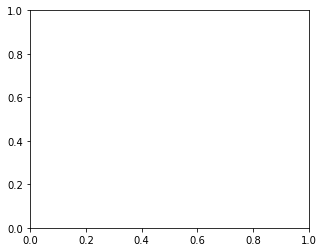

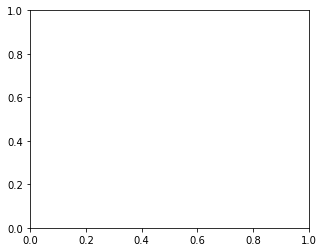

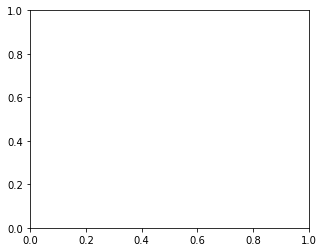

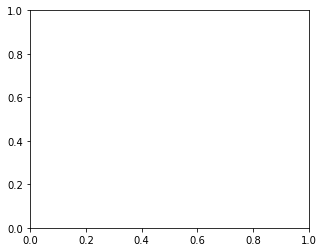

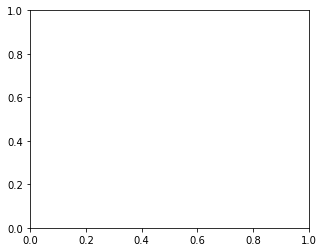

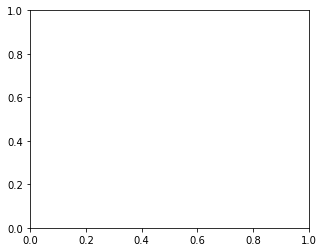

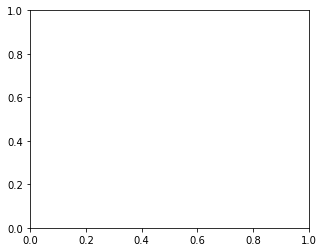

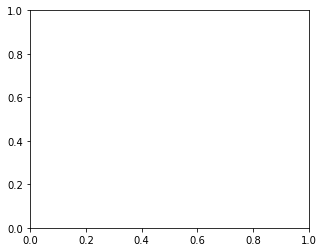

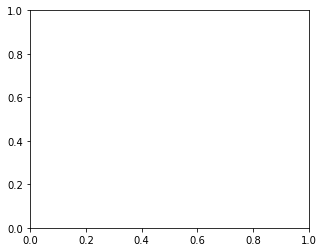

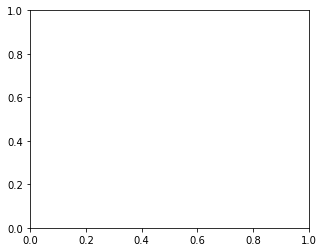

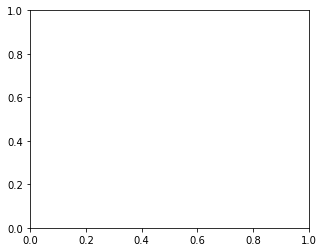

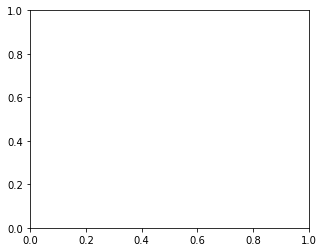

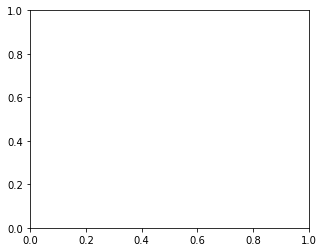

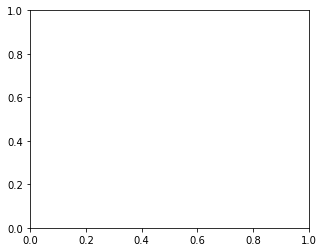

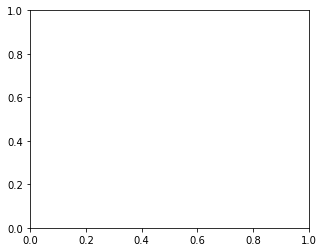

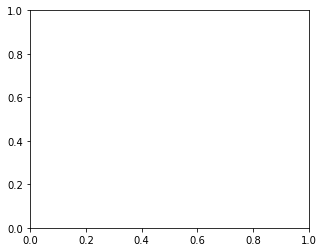

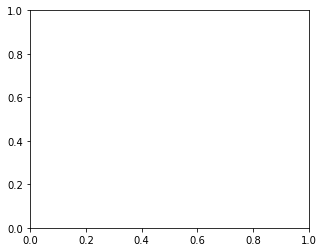

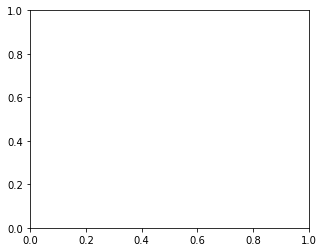

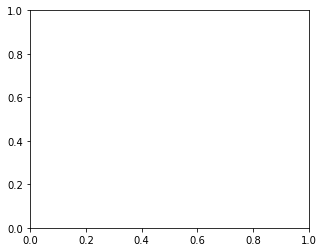

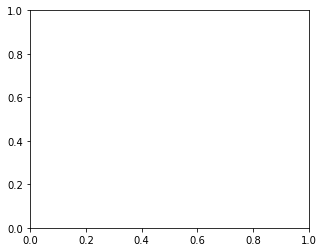

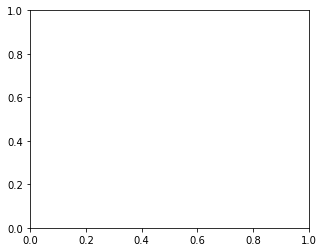

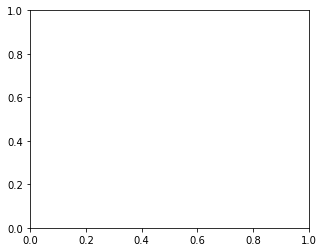

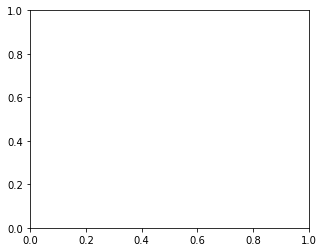

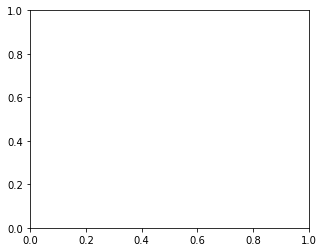

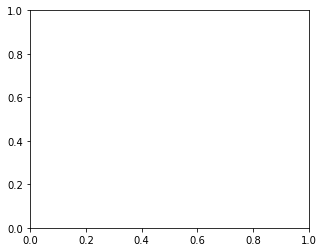

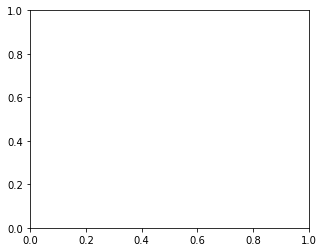

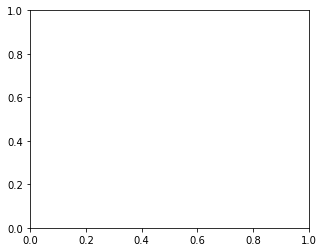

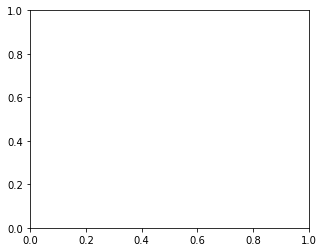

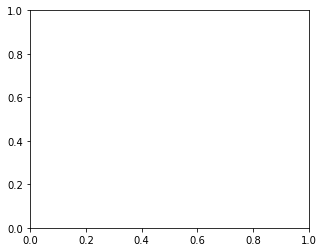

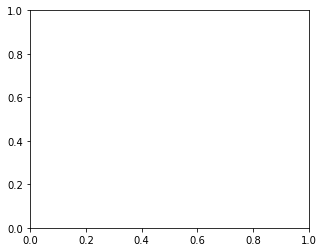

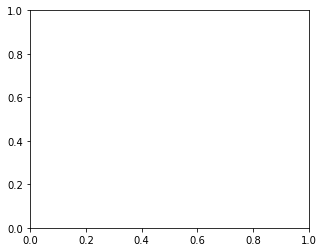

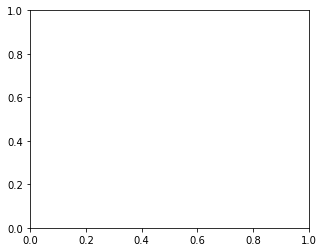

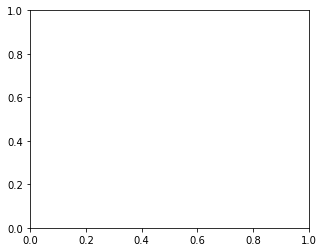

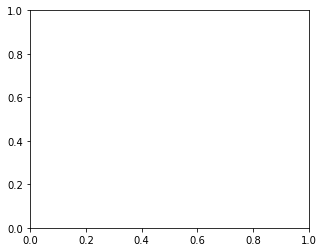

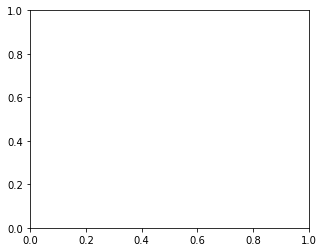

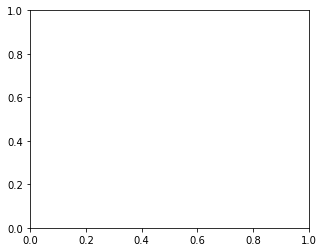

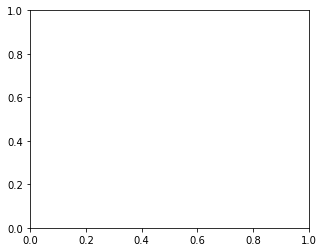

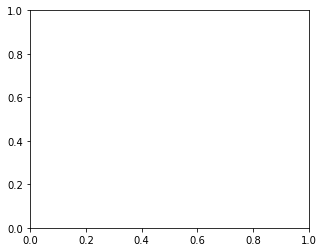

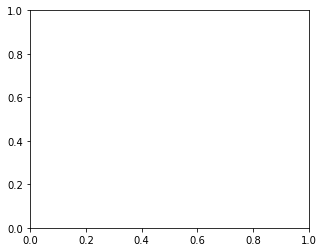

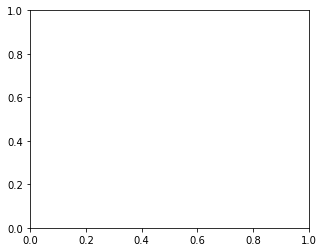

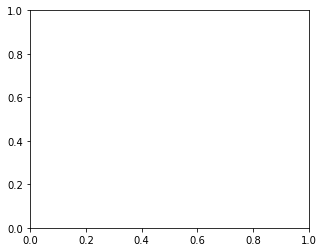

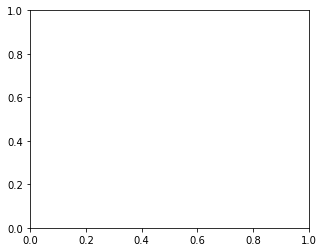

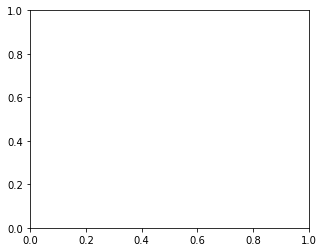

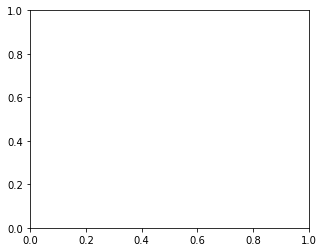

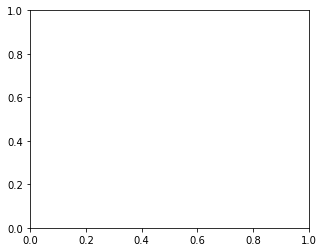

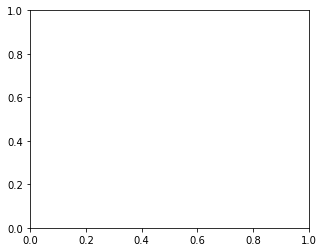

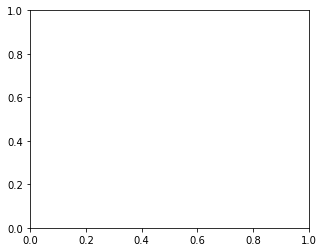

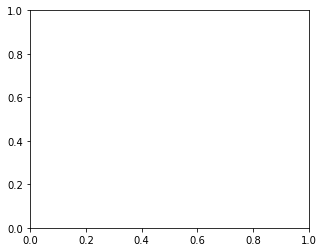

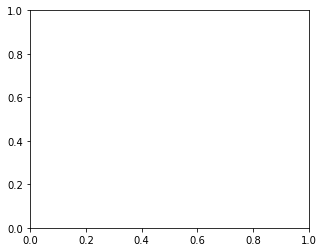

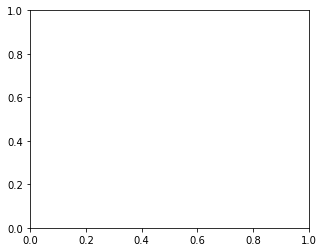

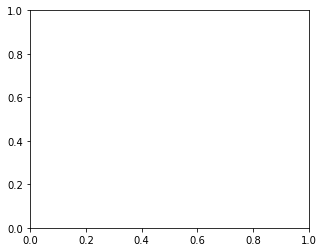

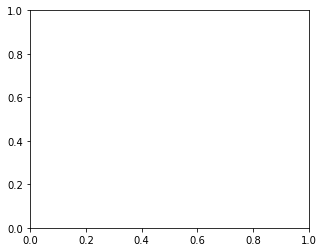

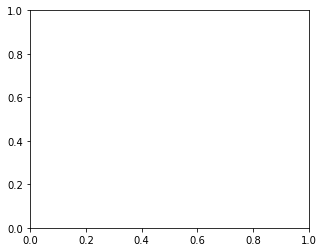

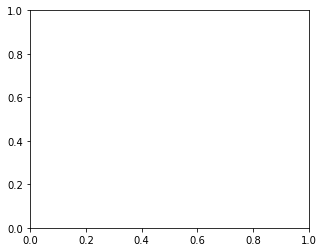

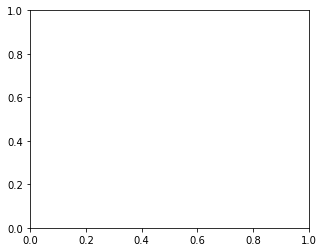

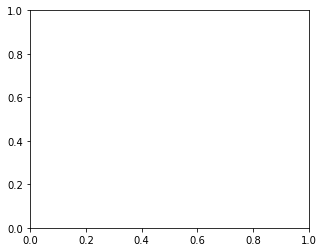

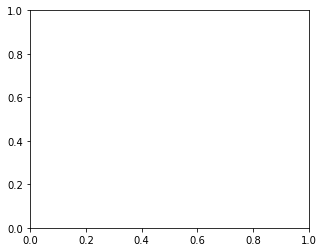

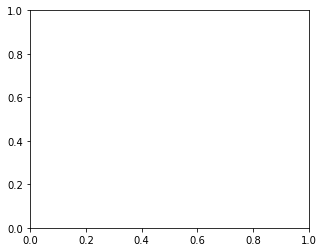

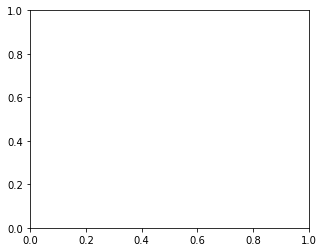

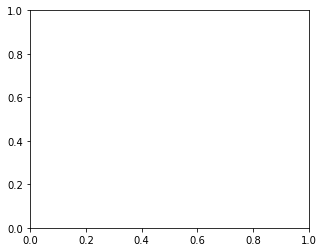

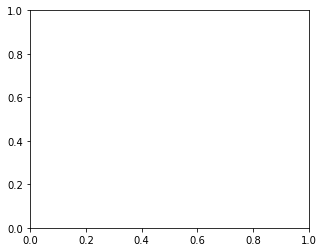

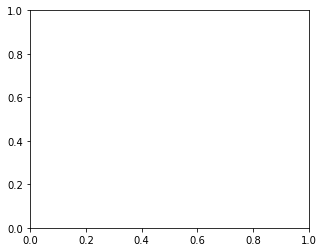

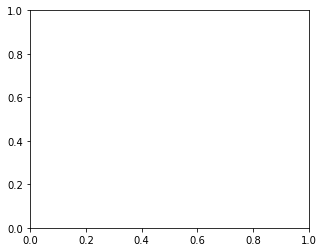

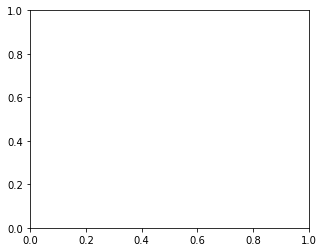

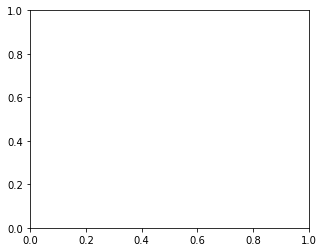

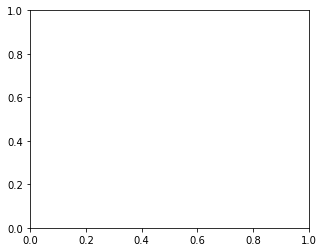

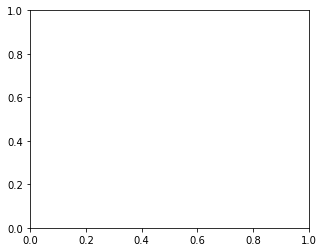

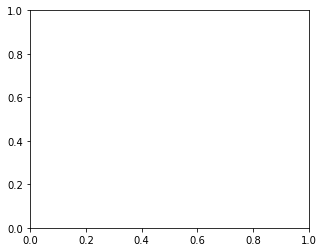

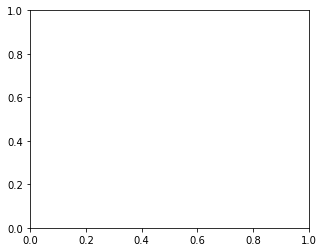

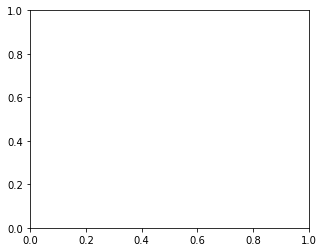

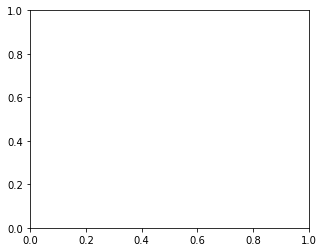

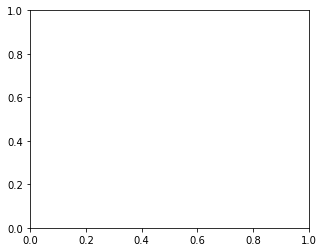

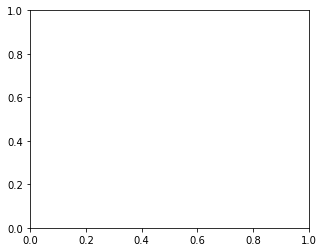

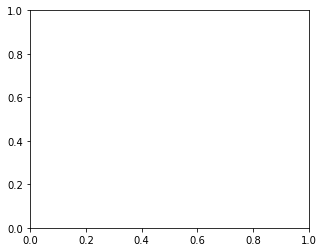

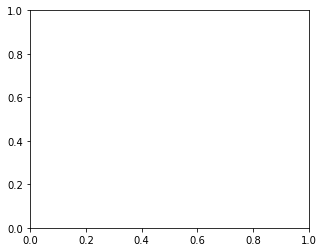

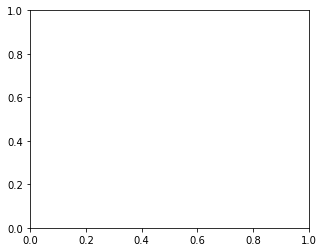

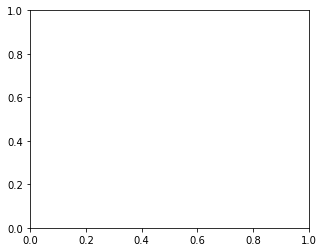

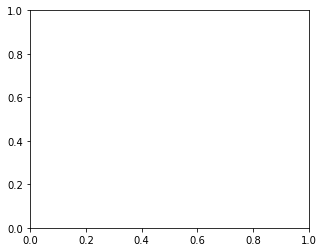

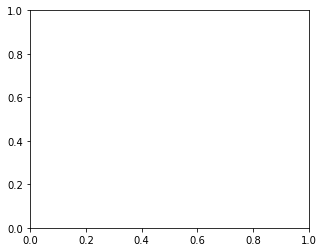

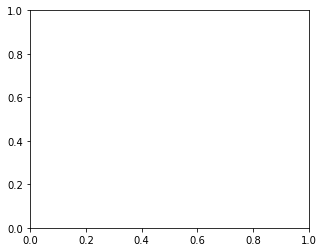

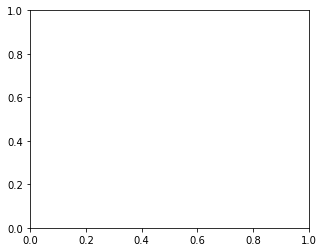

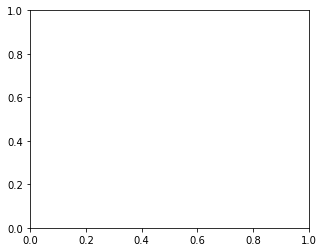

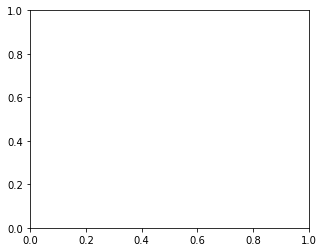

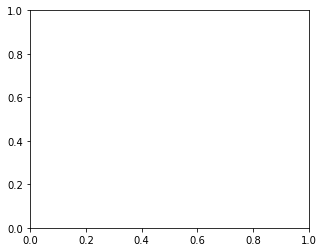

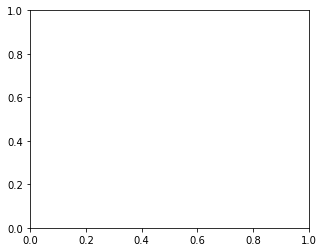

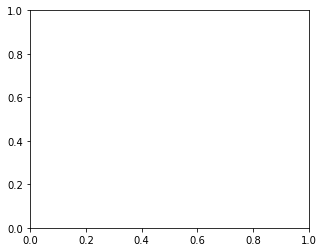

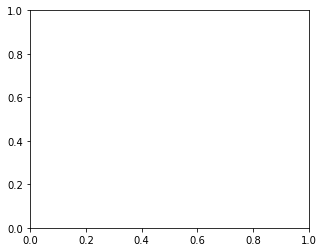

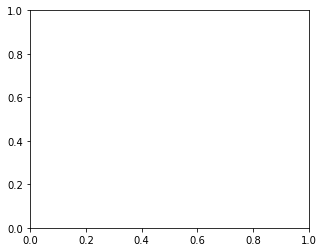

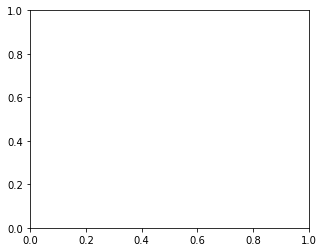

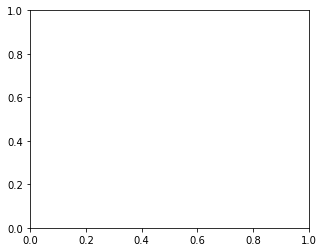

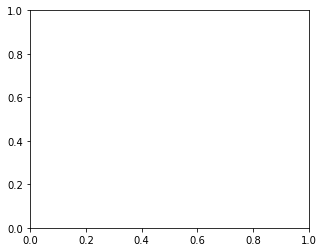

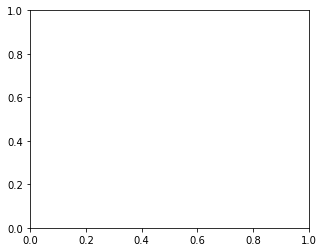

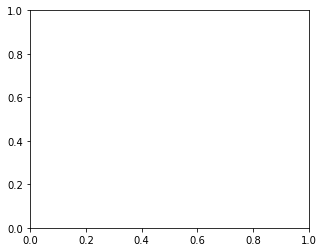

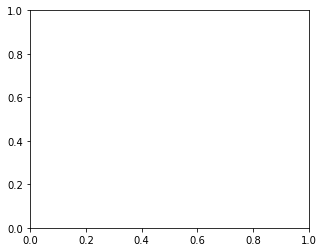

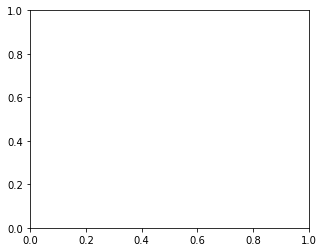

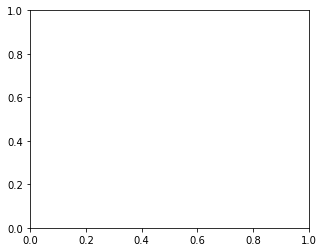

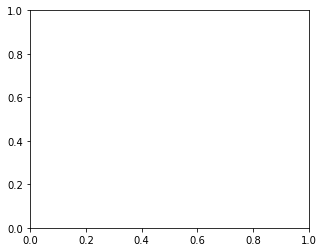

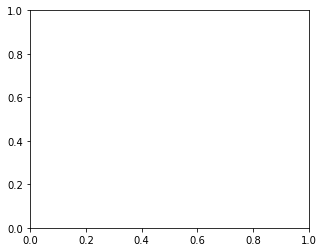

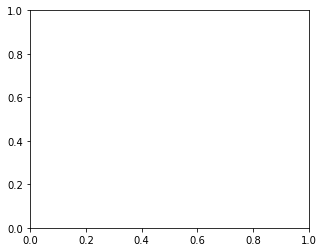

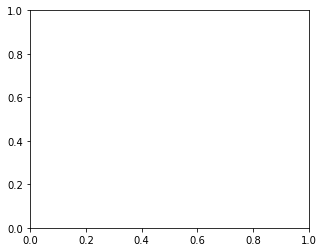

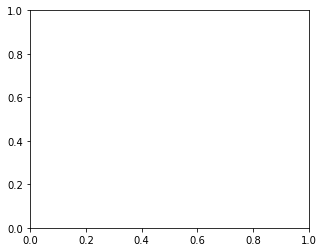

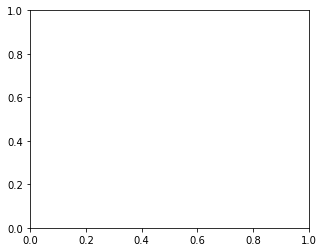

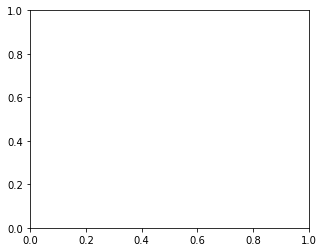

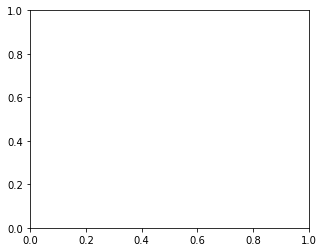

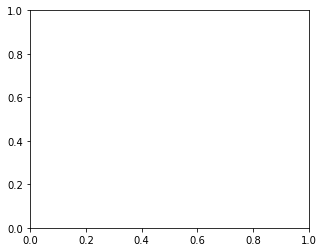

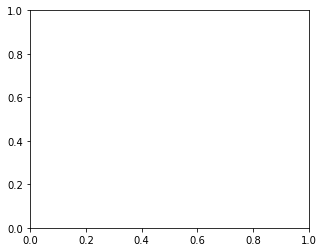

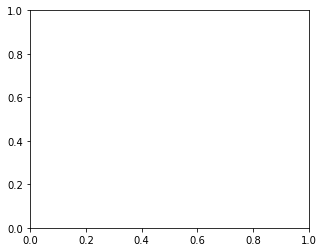

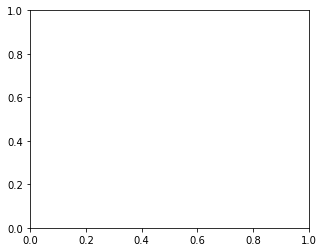

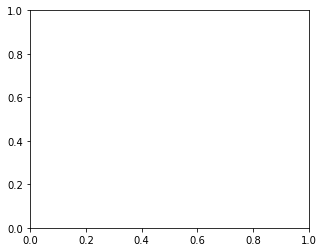

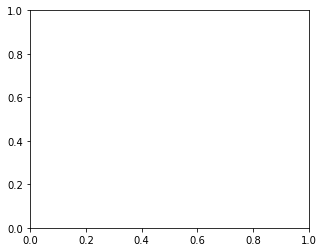

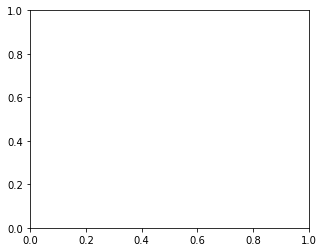

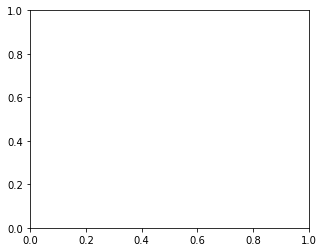

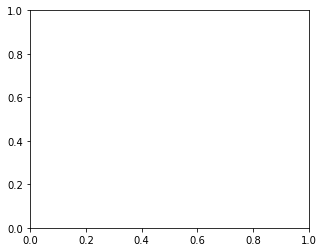

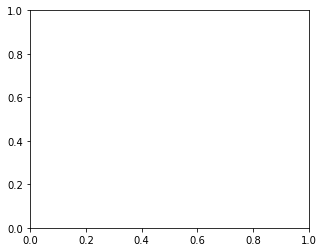

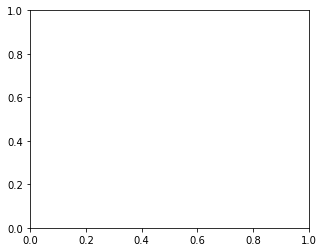

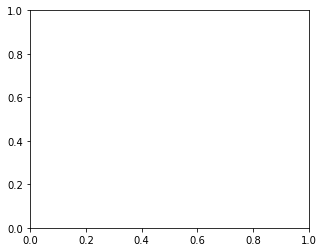

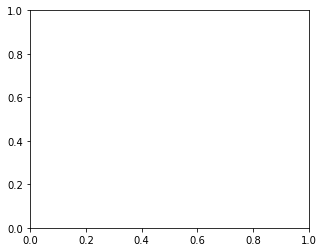

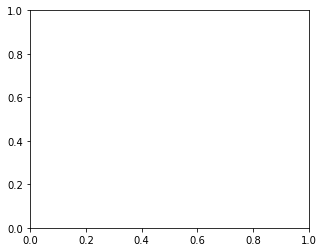

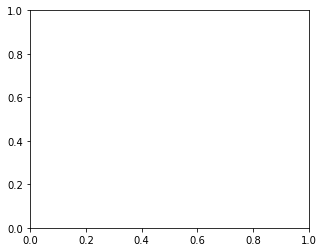

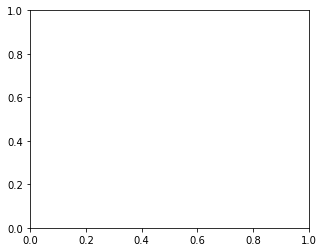

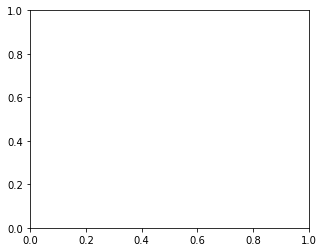

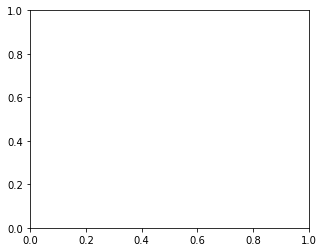

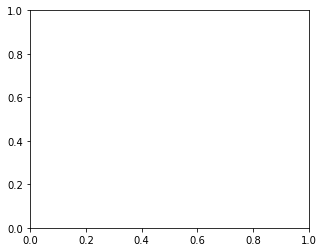

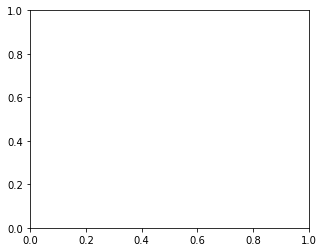

In [10]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')

cell_before = []
cell_after = []

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']
    
    if trial_valid_after.sum()<30:
        continue
    
    ### plot combined
    
    
    for n_cell in range(sub_swim.shape[0]):
        spk_list = spk_swim[n_cell]
        if spk_list.sum()<100:
            continue

        ave_ = spk_list[trial_valid, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_before.append(mean_)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = sem(ave_, axis=0, nan_policy='omit')
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        spk_list = spk_swim_after[n_cell]
        ave_ = spk_list[trial_valid_after, :]*300
        mean_ = np.nanmean(ave_, axis=0)
        cell_after.append(mean_)
#         max_ = mean_.max()
#         min_ = mean_.min()
#         std_ = sem(ave_, axis=0, nan_policy='omit')
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
#         ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
#         ax[0].set_xlim([-t_pre/300, t_post/300])
#         ax[0].set_xlabel('Time (sec)')
#         ax[0].set_ylabel('dF/F')
#         sns.despine()
#         ax[0].set_title([folder, fish, n_cell])

In [11]:
plt.close('all')

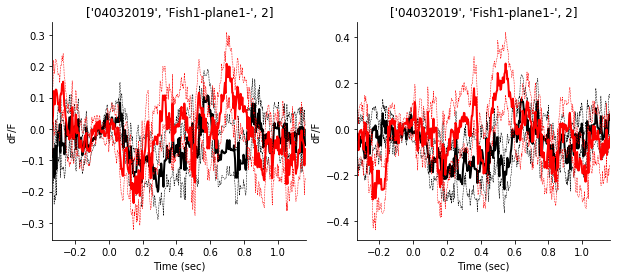

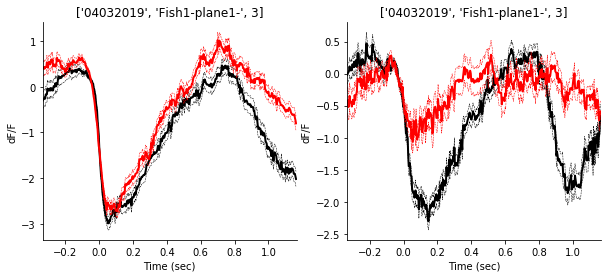

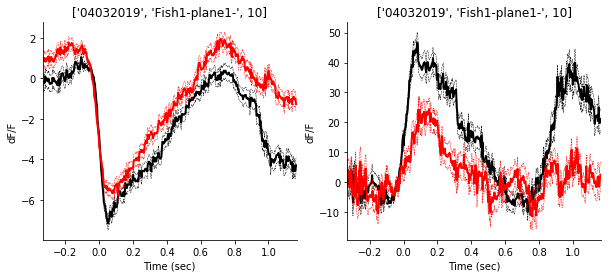

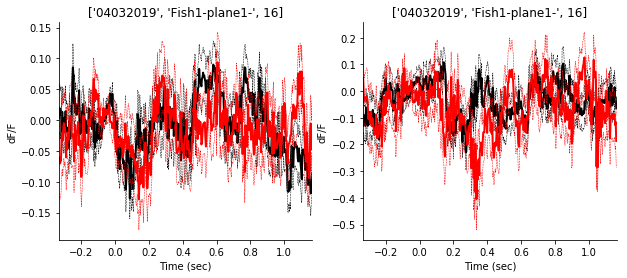

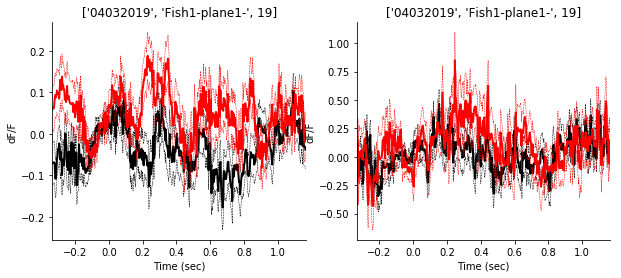

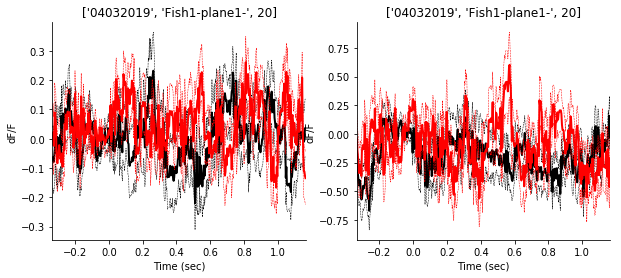

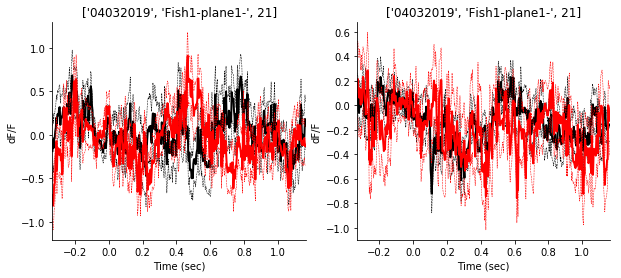

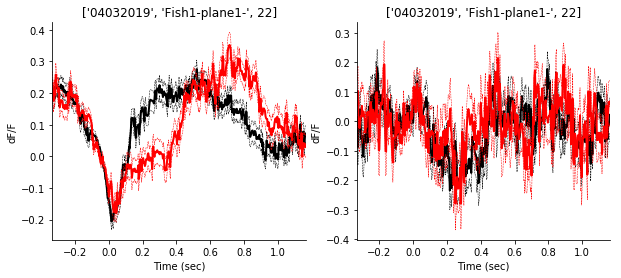

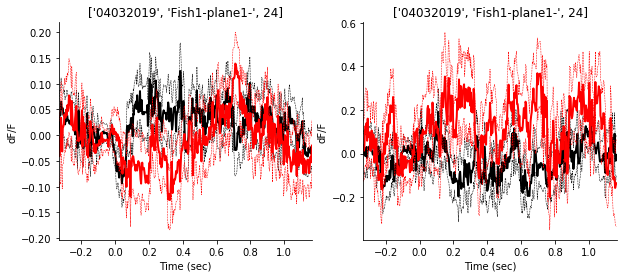

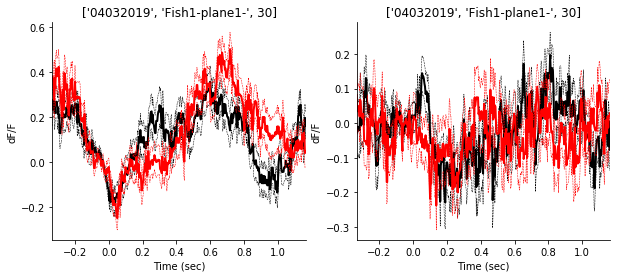

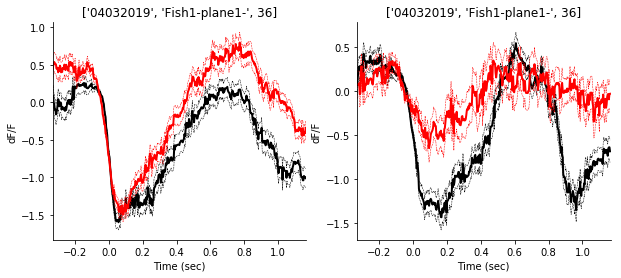

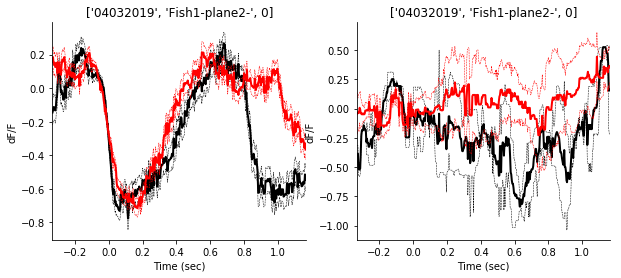

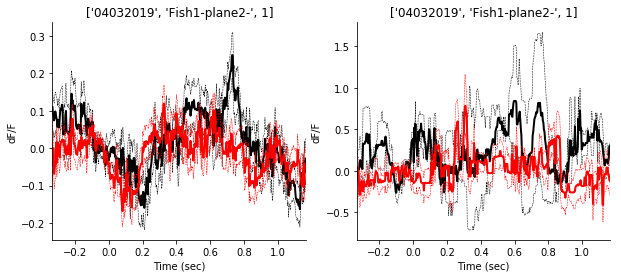

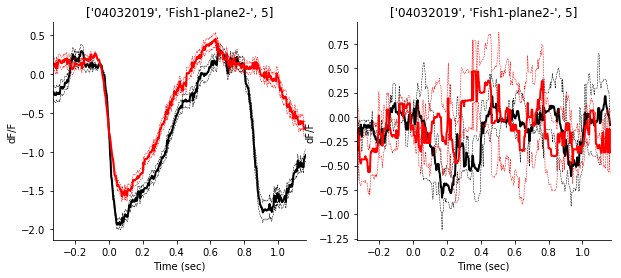

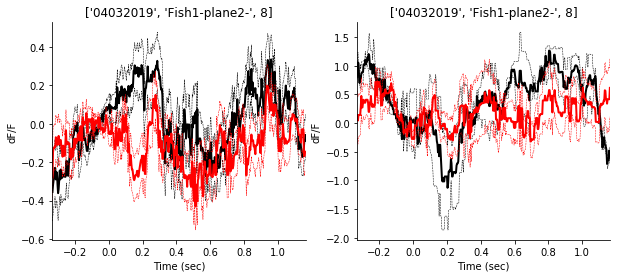

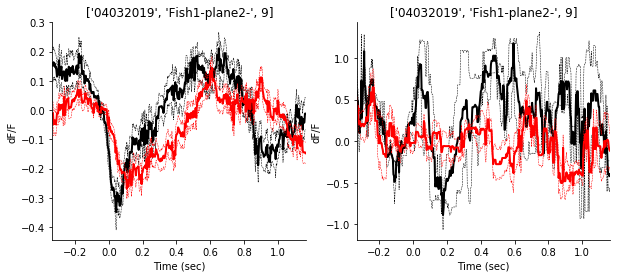

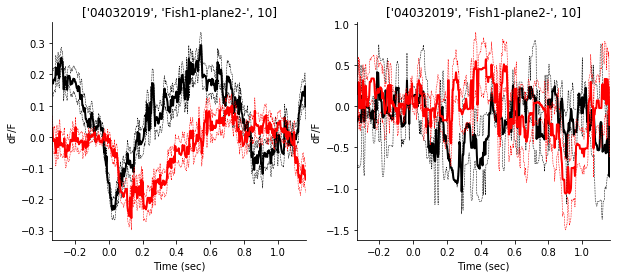

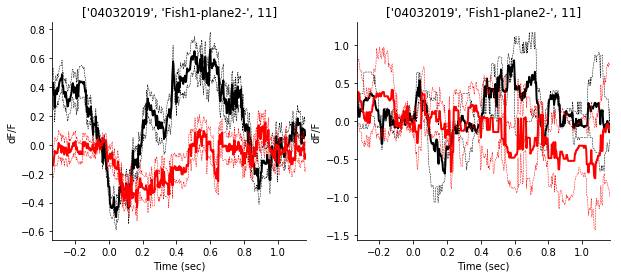

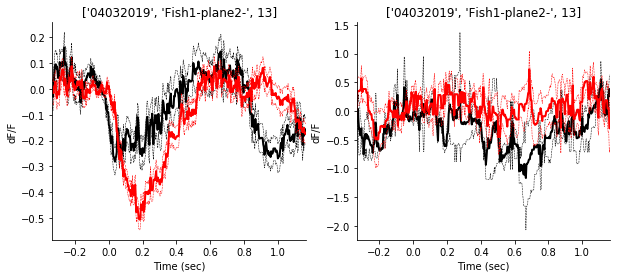

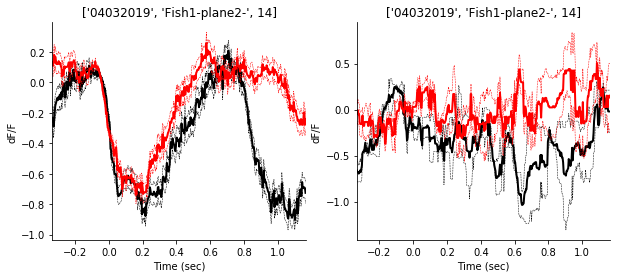

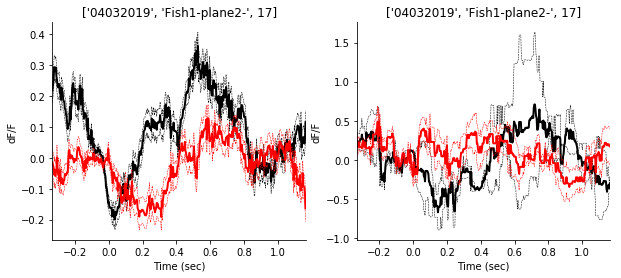

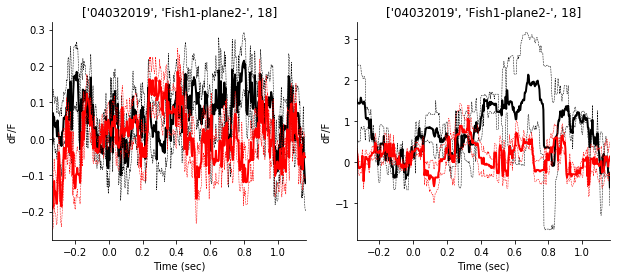

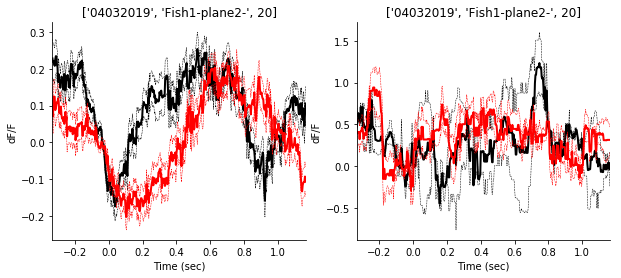

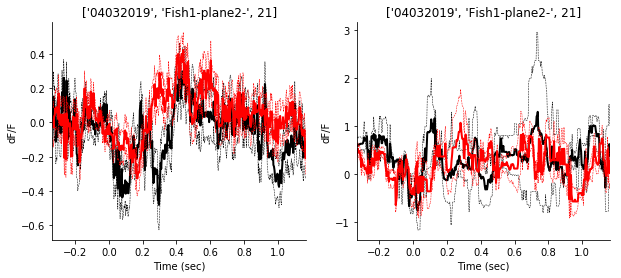

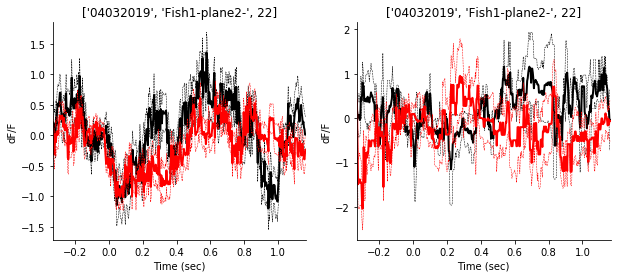

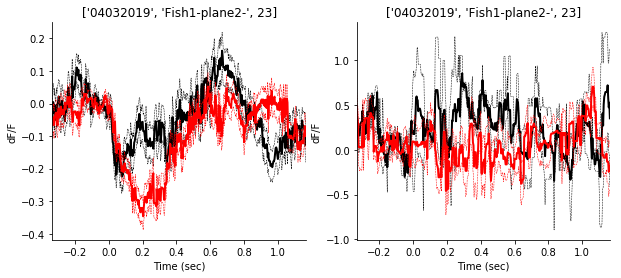

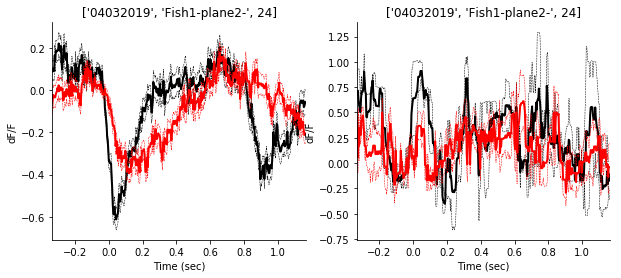

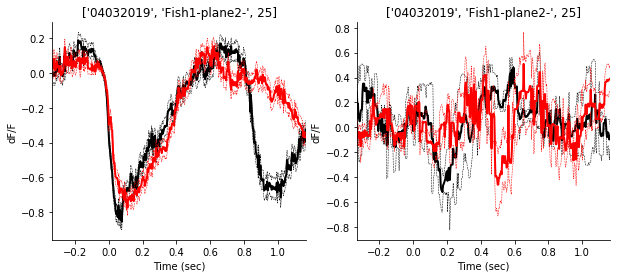

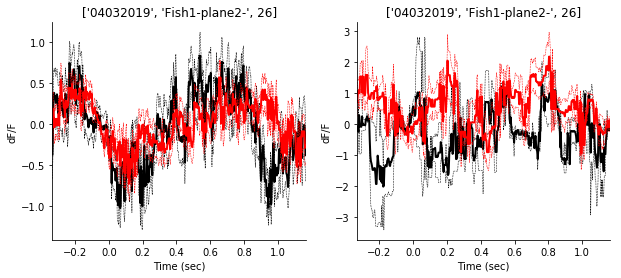

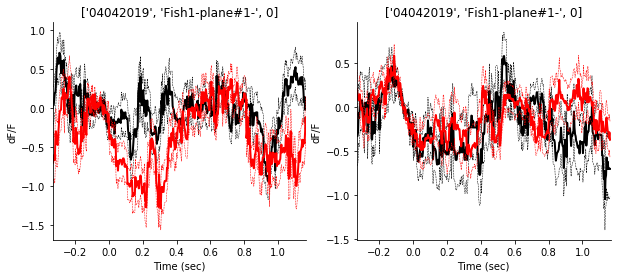

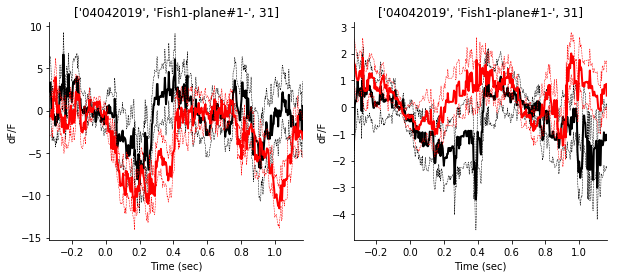

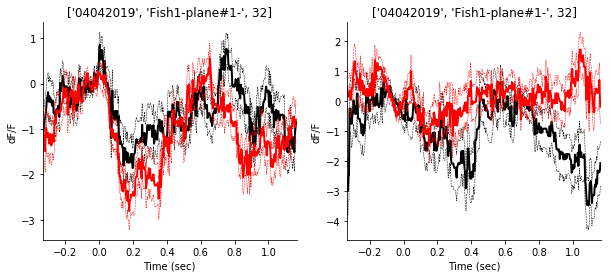

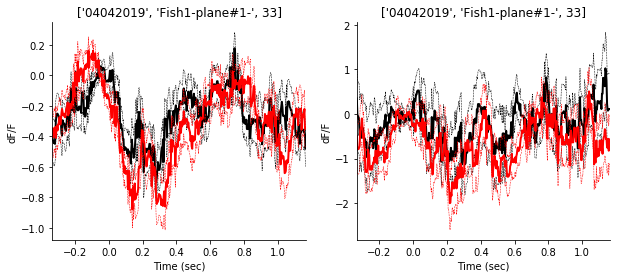

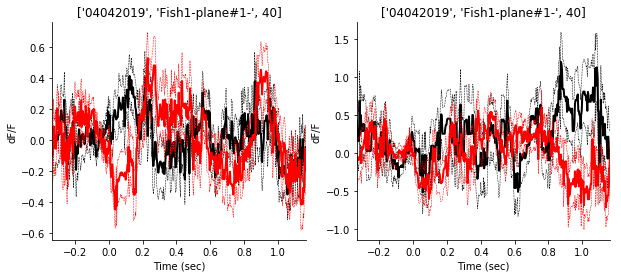

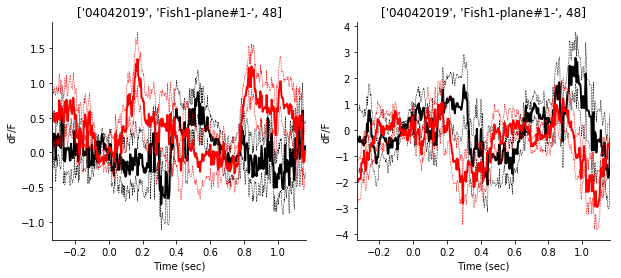

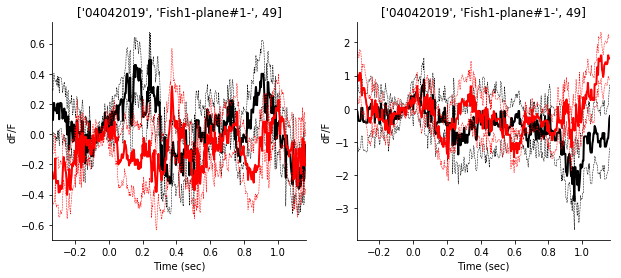

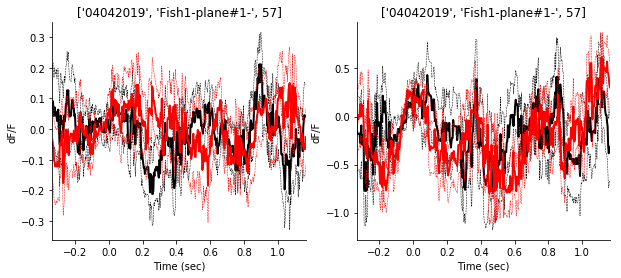

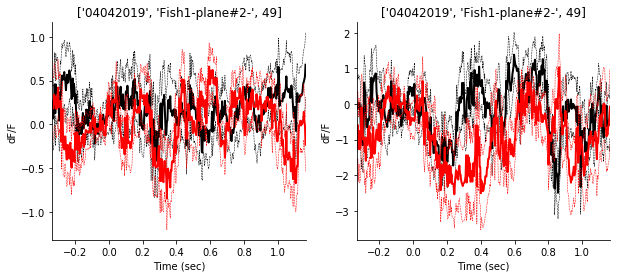

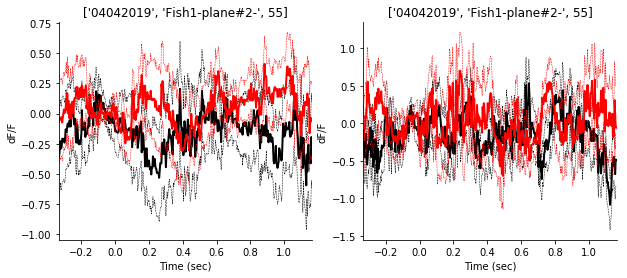

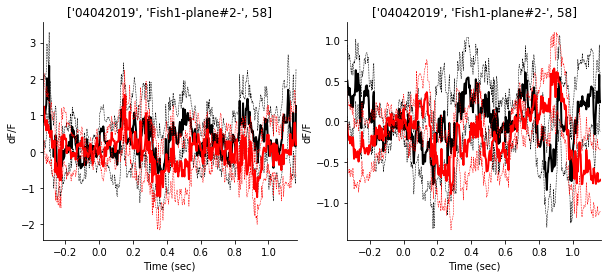

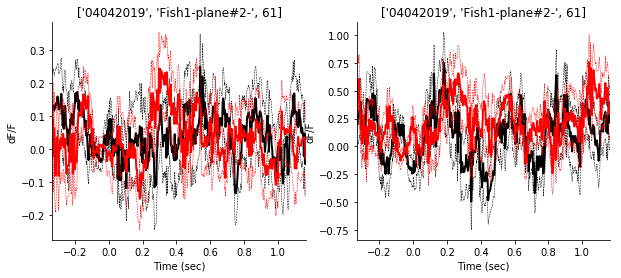

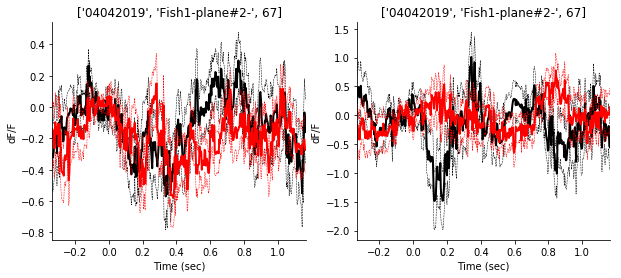

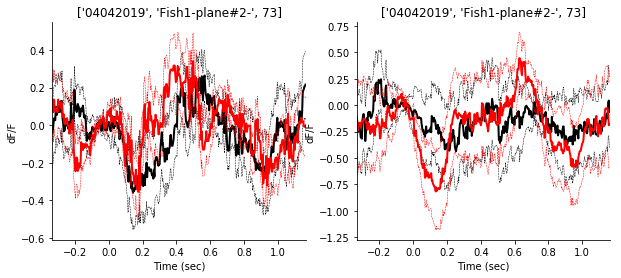

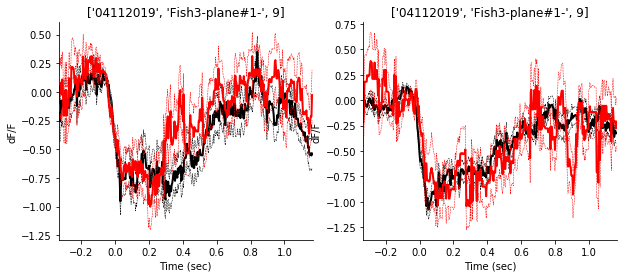

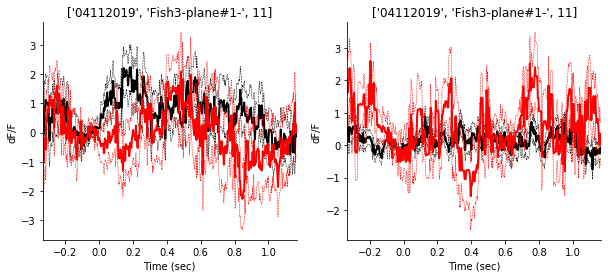

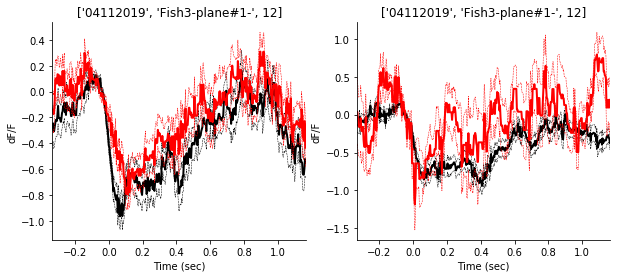

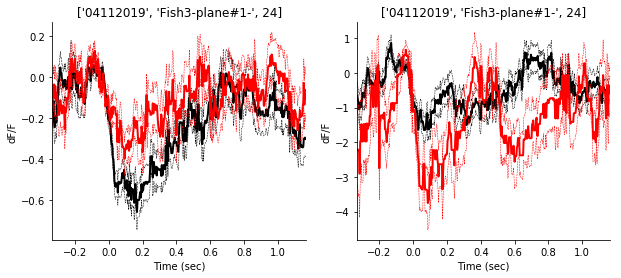

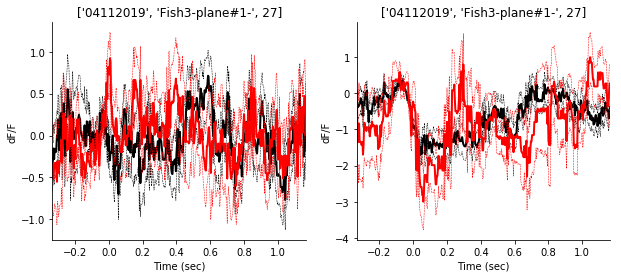

In [5]:
valid_ind = np.zeros(len(dat_xls_file)).astype('bool')

for ind, row in dat_xls_file.iterrows():
    ablation_pair = search_paired_data(row, dat_xls_file)
    
    if not ablation_pair:
        continue
    
    folder = row['folder']
    fish = row['fish'][:-6]
    task_type = row['task']
    
    ##### before
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}before_swim_dat.npz')
    task_period = _['task_period']            
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}before_swim_voltr_dat.npz')
    sub_swim = _['sub_swim']
    spk_swim = _['spk_swim']
    sub_sig_swim = _['sub_sig_swim']
    trial_valid = _['trial_valid']
    
    ##### after
    _ = np.load(f'../Analysis/swim_power/{folder}_{fish}after_swim_dat.npz')
    task_period_after = _['task_period']
    _ = np.load(f'../Analysis/swim_voltr/{folder}_{fish}after_swim_voltr_dat.npz')
    sub_swim_after = _['sub_swim']
    spk_swim_after = _['spk_swim']
    sub_sig_swim_after = _['sub_sig_swim']
    trial_valid_after = _['trial_valid']
    
    ### plot combined
    
    for n_cell in range(sub_swim.shape[0]):
        sub_sig = sub_sig_swim[n_cell]
        sub_list = sub_swim[n_cell]
        sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim[n_cell]
        if spk_list.sum()<200:
            continue
            
        fig, ax = plt.subplots(1, 2, figsize=(10, 4))   
        ave_ = sub_list[(task_period==1) & trial_valid, :]*100
        mean_ = np.nanmedian(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = sem(ave_, axis=0, nan_policy='omit')
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        ave_ = sub_list[(task_period==2) & trial_valid, :]*100
        mean_ = np.nanmedian(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
        ax[0].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
        # plt.ylim([0, 2.2])
        ax[0].set_xlim([-t_pre/300, t_post/300])
        # plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
        ax[0].set_xlabel('Time (sec)')
        ax[0].set_ylabel('dF/F')
        sns.despine()
        ax[0].set_title([folder, fish, n_cell])
        
        sub_sig = sub_sig_swim_after[n_cell]
        sub_list = sub_swim_after[n_cell]
        sub_list = sub_list - sub_list[:, (t_pre-30):t_pre].mean(axis=-1, keepdims=True)
        spk_list = spk_swim_after[n_cell]
        
        ave_ = sub_list[(task_period_after==1) & trial_valid_after, :]*100
        mean_ = np.nanmedian(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = sem(ave_, axis=0, nan_policy='omit')
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_, '-k', lw=2)
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--k', lw=0.5)
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--k', lw=0.5)
        
        ave_ = sub_list[(task_period_after==2) & trial_valid_after, :]*100
        mean_ = np.nanmedian(ave_, axis=0)
        max_ = mean_.max()
        min_ = mean_.min()
        std_ = np.nanstd(ave_, axis=0)/np.sqrt(ave_.shape[0])
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_, '-r', lw=2)
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_-std_, '--r', lw=0.5)
        ax[1].plot(np.arange(-t_pre, t_post)/300, mean_+std_, '--r', lw=0.5)
        
        # plt.ylim([0, 2.2])
        ax[1].set_xlim([-t_pre/300, t_post/300])
        # plt.vlines([0], [min_-np.abs(min_)*0.1], [max_+np.abs(max_)*0.1], colors='k', linestyles='--')
        ax[1].set_xlabel('Time (sec)')
        ax[1].set_ylabel('dF/F')
        sns.despine()
        ax[1].set_title([folder, fish, n_cell])
        
        plt.show()